#  Exercices supplémentaires



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personnalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=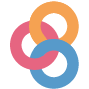)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)

Cette page approfondit certains aspects présentés dans les autres tutoriels. Il s'agit d'une suite d'exercice, avec corrections, pour présenter d'autres aspects du NLP ou pratiquer sur des données différentes

# Exploration des libellés de l'openfood database

L'objectif de cet exercice est d'analyser les termes les plus fréquents
dans les noms de produits de l'openfood database. Au passage, cela permet de réviser les étapes de *preprocessing* (LIEN XXXXX) et d'explorer les enjeux de reconnaissance d'entités nommées. 

Dans cet exercice:

* tokenisation (`nltk`)
* retrait des stop words (`nltk`)
* nuage de mots (`wordcloud`)
* reconnaissance du langage (`fasttext`)
* reconnaissance d'entités nommées (`spacy`)

le tout sur l'OpenFood Database, une base de données alimentaire qui est enrichie de manière collaborative. 

Pour pouvoir utiliser les modèles pré-entraînés de `spaCy`, il faut les télécharger. La méthode préconisée est d'utiliser, depuis un terminal, la commande suivante

In [ ]:
python -m spacy download fr_core_news_sm

Dans un notebook jupyter, il se peut qu'il soit nécessaire de relancer le kernel.

Si l'accès à la ligne de commande n'est pas possible, ou si la commande échoue, il est possible de télécharger le modèle pré-entraîné directement depuis une session `Python`

In [ ]:
import spacy
spacy.cli.download('fr_core_news_sm')

1. Importer le modèle de reconnaissance de langage qui sera utilisé par la suite
ainsi que le corpus Français utilisé par `spacy`



2. Importer les données de l'[openfood database](https://fr.openfoodfacts.org/data) à partir du code suivant

```
## ('/tmp/tmpw1v42ld3.openfood.csv', <http.client.HTTPMessage object at 0x7f4da7751100>)
```

Ces données devraient avoir l'aspect suivant:

```
##      product_name
## 0  jeunes pousses
## 1         L.casei
```

3. Créer une fonction de nettoyage des noms de produits effectuant les 
étapes suivantes:

* tokeniser le texte en question
* retirer la ponctuation et les _stopwords_

Appliquer cette fonction à l'ensemble des noms de produits (variable
`product_name`)


4. Effectuer un nuage de mot sur les libellés avant et après nettoyage
pour comprendre la structure du corpus en question.
Le résultat devrait avoir l'apparence suivante




5. Utiliser la librairie `fasttext` pour extraire les noms de produits
français

* Appliquer le modèle téléchargé précedemment pour déterminer le langage
* Ne récupérer que les libellés français

```
## Warning : `load_model` does not return WordVectorModel or SupervisedModel any more, but a `FastText` object which is very similar.
```

```
##                    product_name             tokenized language  score_language
## 0                jeunes pousses        jeunes pousses       fr        0.971347
## 7   moutarde au moût de raisin   moutarde moût raisin       fr        0.990018
```

6. Visualiser avec `spacy.displacy` le résultat d'une reconnaissance
d'entités nommées sur 50 données aléatoires. Cela vous semble-t-il satisfaisant ?


<!DOCTYPE html>
<html lang="fr">
    <head>
        <title>displaCy</title>
    </head>

    <body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol'; padding: 4rem 2rem; direction: ltr">
<figure style="margin-bottom: 6rem">
<div class="entities" style="line-height: 2.5; direction: ltr">Gelée Extra Groseilles </br> PÉRÈNE 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    CAMPAGNE
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Escalopes
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 de dinde (4 pièces) </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Tranche
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 de pain </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Tartinade
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 avec des graines de courge - Potimarron - Carotte </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Danette
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 La barquette, format famillial </br> L'idylle blanche </br> BBMix 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Ace 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
Douceur de 9 légumes avec une touche de crème </br> Brioche Tressée Aux 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Pépites De Chocolat
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Jambon
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 a l'ancienne </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Rillettes
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 de saumon à l'aneth </br> Fraises du perigord </br> Craquant choco </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Huile
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 d'olive à la truffe blanche </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Gros Pigeonneaux
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 - Par Caisse De 10 </br> Haricots verts très fins </br> Les galettes de pont-aven </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Huile De Tournesol
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
, 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Bidon De 2 Litres
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
, 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Marque
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 Cora </br> Demi baguette </br> Fruits et graines du monde grilles </br> Tradition graines maison </br> Madeleines choconoir </br> Saucisson Cuit à l'
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Ail Fumé 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
Filet de poulet au curry </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Nougat
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 artisanal à la fraise 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Tagada
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 de 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    HARIBO
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Gelée de Zeb
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 a 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Pik 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
Knorr Les 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Classiques Soupe Liquide Douceur de 8 Légumes
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 à la 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Crème Fraîche
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 Lot 2x1L </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Darne
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 de saumon rose du 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Pacifique
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 au naturel </br> Les galettes d’annette framboise </br> Flan a la semoule </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Crème
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 glacée café marbrée café </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Jambon
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 sec superieur de savoie 4 tranches </br> Palais des thé </br> Bloc de foie gras d‘oie avec morceaux </br> Pomme fraise </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Tranche
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 d’emmental </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Magret de Canard 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
Gratin aux 2 saumons, pommes de terre &amp; petits légumes </br> Saucisses superieures indiennes </br> Le burger classique </br> Gâteau breton aux oeufs frais </br> Mélange bien-être </br> 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Meringues Torsadées
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 parfum vanille, 150g </br> Pac sirop citron sans colorant </br> Sirop de 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Kiwi 
 Cassolette
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 volaille et ris de veau </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Mystère
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 coco cœur chocolat </br> Pain de volaille </br> Bouillon aux tomates</div>
</figure>
</body>
</html>

7. Récupérer dans un vecteur les entités nommées reconnues par `spaCy`.
Regarder les entités reconnues dans les 20 premiers libellés de produits 

```
## [[], [], [('Pistou', 'PER')], [], [('Limonade', 'PER')], [('Sachet', 'PER')], [], [], [('Salade', 'PER')], [], [('Vainilla', 'PER')], [], [('Solène', 'PER')], [], [('Caramel', 'ORG')], [('Salade', 'PER')], [], [], [], [('Bouillie', 'PER')]]
```

<!----
# State of the union address

Un exercice à venir sur l'analyse des discours des présidents américains 
inspiré de https://github.com/BuzzFeedNews/2018-01-trump-state-of-the-union
---->